<h1>Importação de bibliotecas que serão utilizadas no código</h1>

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

<h1>Aqui definimos o que iremos utilizar para o processamento, GPU ou CPU.

Encontrei alguns erros utilizando a GPU, então optei por utilizar a CPU.</h1>

In [4]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device('cpu')
device = "cpu"
device

'cpu'

<h1>Aqui obtemos os pesos pré-treinados do transformer do pytorch<br>
Configuramos uma instância de um ViT<br>
Congelamos os parâmetros das camadas intermediarias<br>
Definimos as classes</h1>

In [5]:
#Aqui nós obtemos pesos pré-treinados da base de Vision Transformers do pytorch
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

#Aqui configuramos uma instância de modelo de Vision Transformers com os pesos pré-treinados
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#Aqui iremos congelar os parâmetros, para que não tenham seus valores atualizados durante o treinamento
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
#Aqui definimos as classes que queremos utilizar
class_names = ['rose','sunflower']

#Aqui definimos a dimensão dos embbedings como 768
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


<h1>Aqui definimos um batch de 32 imagens, com 3 canais de cores (RGB) e dimensões de 224x224

O encoder possui 1 camada de dropout, 12 camada sequenciais e uma camada de normalização.</h1>

In [6]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

C:\Users\heito\anaconda3\lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

<h1>Apenas a camada de saída é treinável, pois estamos utilizando um modelo pré-treinado, todas as outras camadas não podem ser treinadas, estão congeladas.</h1>

In [7]:
# Aqui definimos os caminhos onde as imagens estão armazenadas
train_dir = 'train'
test_dir = 'test'

In [8]:
#Aqui são realizadas etapas de pré-processamento para garantir que as imagens estejam no mesmo formato de seu treino
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


<h1>Agora, criamos DataLoaders, que são utilizados no pytorch para treinamento, a partir das nossas imagens</h1>

In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Aqui nos obtemos o número de CPUs disponíveis para utilizarmos durante o treino
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  #Aqui nós criamos os datasets de treino e de teste
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  #Aqui obtemos os nomes das classes que iremos utilizar no modelo
  class_names = train_data.classes

  #Aqui transformamos as imagens em DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

<h1>Aqui criamos de fato os DataLoaders para o treinamento do modelo</h1>

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [10]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [12]:
from going_modular.going_modular import engine

# Criamos as funções de otimização e de perda
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Treino da cabeça de classificador do ViT pré-treinado
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0057 | train_acc: 1.0000 | test_loss: 0.0013 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0021 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 0.0004 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.0002 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.0002 | test_acc: 1.0000


<h1>Agora faremos algumas predições</h1>

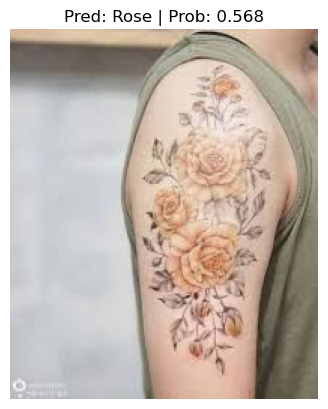

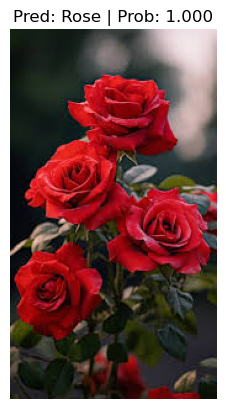

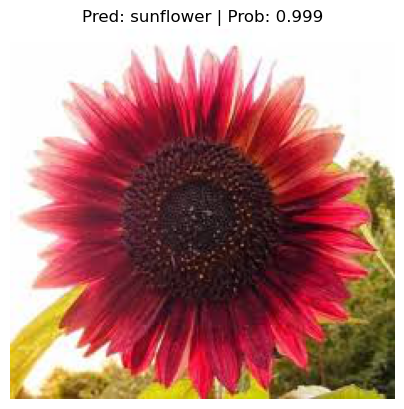

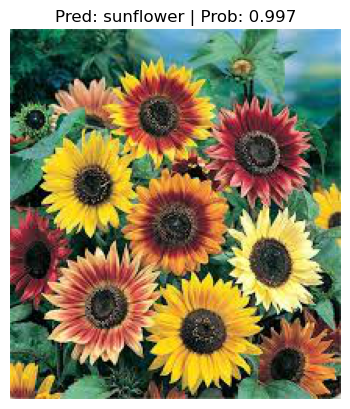

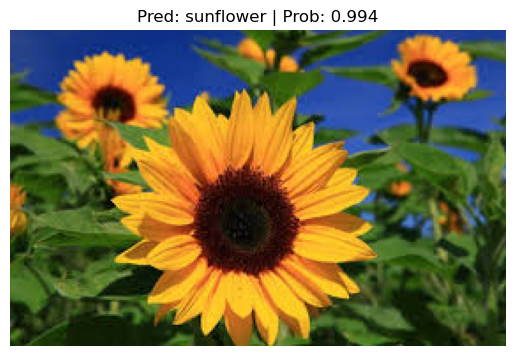

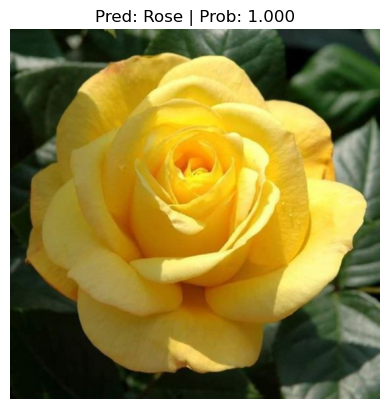

In [16]:
import requests

# Função que faz previsões a partir de imagens e as exibe
from going_modular.going_modular.predictions import pred_and_plot_image

# Previsão na imagem que escolhemos
pred_and_plot_image(model=pretrained_vit,
                    image_path='rosa-tattoo.jpg',
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path='rosa.jpeg',
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path='girassol-verm.jpeg',
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path='girassol.jpeg',
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path='girassolbonito.jpeg',
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path='rosa-amarela.jpg',
                    class_names=class_names)